# Visualising South Park dialogues and predicting speaker

This notebook explores different tools to visualise the Kaggle South Park Dialogues dataset and explore differences in speech between characters. Next, it builds an sklearn pipeline to predict which character a line belongs to. 

# First, some imports

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import brown
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD # for LSA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.layouts import column, row
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import  LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

# Second, a few useful functions

In [26]:
def normalize_text(text):
    '''Processes free text to normalise it before analysis.

    Args:
        text (str): The text to be processed

    Returns:
        str: The processed version of the text'''
    
    #Tokenise words
    text = nltk.word_tokenize(text)
    #Lowercase
    text = [word.lower() for word in text]
    #Remove punctuation and special characters
    text = [word for word in text if word not in string.punctuation]
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if not word.isdigit()]
    #Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text = [word for word in text if word not in stopwords]
    #Lemmatize
    wnl = nltk.WordNetLemmatizer()
    text = [wnl.lemmatize(word) for word in text]
    return text

In [27]:
def get_tfidf_frequencies (df, txt_col, cat_col):  
    '''Groups a column of text by a categorical variable and calculates tf-idf by category. 
    
    Args:
        df: a pandas dataframe
        text_col: the column containing text
        cat_col: the column containing the categorical variable
        
    Returns: 
        A list of lists containing (word, tfidf) tuples where each item in the list holds 
        the (word, tfidf) values for one cat_col value.
    '''    

    documents = df.groupby(cat_col)[txt_col].apply(lambda x: ' '.join(x.astype(str)))

    corpus = []    
    
    # Build the dictionary
    for idx, row in documents.iteritems():
        text = normalize_text(row)
        corpus.append(text)        
    dictionary = Dictionary(corpus) 
 
    # Convert to vector corpus
    vectors = [dictionary.doc2bow(document) for document in corpus]
 
    # Build TF-IDF model
    tfidf = TfidfModel(vectors)
    word_weights = []
    for i in range(0, len(vectors)):
        weights = tfidf[vectors[i]]
        word_weights.append([(dictionary[pair[0]], pair[1]) for pair in weights])
    
    return word_weights
     

In [28]:
def make_word_cloud(df, txt_col, cat_col):    
    '''Groups a column of text by a categorical variable and prints a word cloud for each category using tfidf weights.
    
    Args:
        df: a pandas dataframe
        text_col: the column containing text
        cat_col: the column containing the categorical variable
        
    Returns: 
        Nothing
    '''
    
    corpus = []

    #Initiate WordCloud instance
    WC = WordCloud(prefer_horizontal=1,
                   random_state=1,
                   width=600,
                   height=400,
                   background_color='White',
                   stopwords='',
                   relative_scaling=0.5,
                   collocations=True,
                   normalize_plurals=False,
                   colormap = 'autumn')
    
    wordcloud = []
    ncat = len(df[cat_col].unique())
    length = ncat *60 /8
    fig = plt.figure(figsize=(20,length))
    for i in range(0,ncat):
        ax = fig.add_subplot(round(ncat+0.4, 1), 2, i+1)
        ax.set_title(sorted(df[cat_col].unique())[i],fontsize=40)
        ax.imshow(
            WC.generate_from_frequencies(
                dict(get_tfidf_frequencies(df, txt_col, cat_col)[i])
            ),
            interpolation = 'bilinear', aspect = 'auto'
        )
        ax.axis('off')

# Import and prepare data

In [29]:
df = pd.read_csv('all-seasons.csv')
df['Line'] = df['Line'].replace({'\n': ' '}, regex=True)
df.head()

Season Episode Character  \
0     10       1      Stan   
1     10       1      Kyle   
2     10       1      Stan   
3     10       1      Chef   
4     10       1      Stan   

                                                                                  Line  
0                                              You guys, you guys! Chef is going away.  
1                                                           Going away? For how long?   
2                                                                            Forever.   
3                                                                     I'm sorry boys.   
4  Chef said he's been bored, so he joining a group called the Super Adventure Club.

Since we're interested in differences between characters, let's generate a few statistics about the different speakers

In [30]:
len(df['Character'].unique())

3950

So there are almost 4000 different speakers, this seems like a lot! Let's print how many lines the top speakers actually have:

In [31]:
print(df['Character'].value_counts().head(25))

Cartman               9774
Stan                  7680
Kyle                  7099
Butters               2602
Randy                 2467
Mr. Garrison          1002
Chef                   917
Kenny                  881
Sharon                 862
Mr. Mackey             633
Gerald                 626
Jimmy                  597
Wendy                  585
Liane                  582
Sheila                 566
Jimbo                  556
Announcer              407
Stephen                357
Craig                  326
Clyde                  317
Jesus                  312
Linda                  290
Principal Victoria     289
Mrs. Garrison          282
Terrance               282
Name: Character, dtype: int64


It looks like the main 5 characters speak the majority of the dialogues and the rest are secondary speakers - let's extract the  lines from the top 5 and focus the analysis on them. 

In [32]:
top = df.groupby('Character').filter(lambda x: len(x) > 2000)

Now let's 'normalise' the free text to prepare it for analysis using the function defnied above which puts all text in lowercase, strips numbers and punctuation, removes stopwords and applies lemmatisation. 

In [33]:
top = top.assign(norm = top.Line.apply(normalize_text))

Now let's run some checks on the number of meaningful words in a line - we dont want to be stuck with large numbers of one word lines!

In [34]:
top.head()

Season Episode Character  \
0     10       1      Stan   
1     10       1      Kyle   
2     10       1      Stan   
4     10       1      Stan   
9     10       1   Cartman   

                                                                                   Line  \
0                                               You guys, you guys! Chef is going away.   
1                                                            Going away? For how long?    
2                                                                             Forever.    
4   Chef said he's been bored, so he joining a group called the Super Adventure Club.     
9  I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!     

                                                                  norm  
0                                        [guy, guy, chef, going, away]  
1                                                  [going, away, long]  
2                                                            [forever]  
4  [chef, said, bored, joining, group, called, super, adventure, club]  
9                     [gon, na, miss, gon, na, miss, chef, know, tell]

Line length statistics:
 count    29622.000000
mean         5.470630
std          6.090237
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        133.000000
Name: line_length, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002195443D0B8>,
      dtype=object)

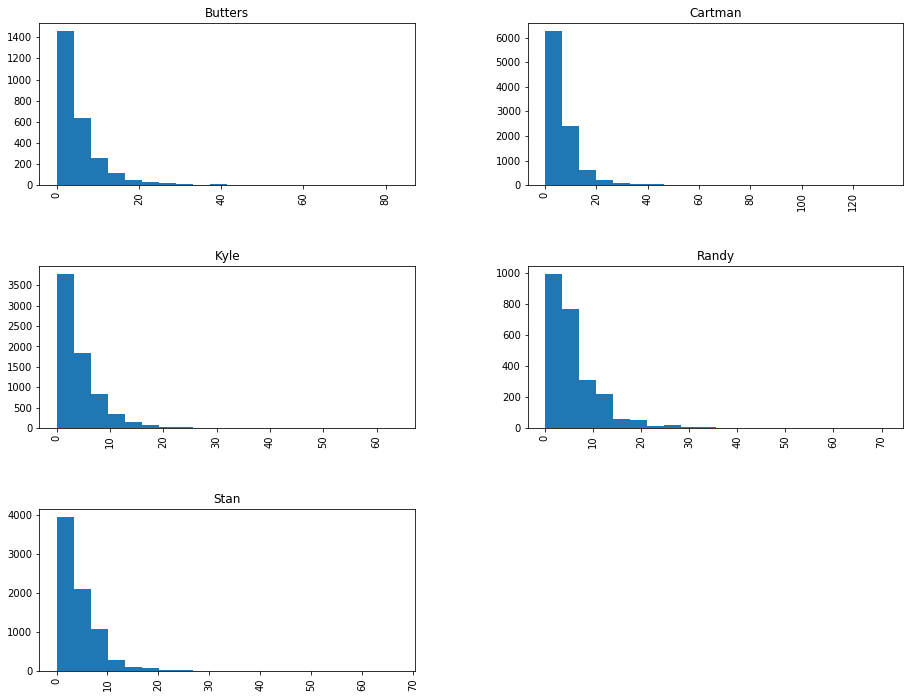

In [35]:
top = top.assign(line_length = top.norm.apply(lambda x: len(x)))
print('Line length statistics:\n', top['line_length'].describe())
top.hist(column='line_length',by='Character',bins=20, figsize=(15,12))

Looks like an exponential distribution with many very short lines - let's get rid of the lines containing less than 6 words - approximately the mean number of words, as these contain less relevant information and will liekly be harder to classify.

In [36]:
top = top[top['line_length']>5]

Let's make sure this selection still represents our 5 characters of interest across all seasons

In [37]:
print(top['Character'].value_counts())
print(top['Season'].value_counts())

Cartman    4218
Stan       2184
Kyle       1942
Randy      1006
Butters     922
Name: Character, dtype: int64
6     868
4     689
7     681
8     637
16    631
3     624
5     606
2     586
13    585
9     582
11    527
15    504
1     502
18    493
10    477
12    450
14    443
17    387
Name: Season, dtype: int64


Ok this looks fine - the last processing step is to put our normalised text column back in free text format rather than a list of words  as this is what the text processing modules we will use expect. 

In [38]:
top['norm'] = top['norm'].apply(lambda x: ' '.join([item for item in x]))
top.head()

Season Episode Character  \
4      10       1      Stan   
9      10       1   Cartman   
10     10       1      Stan   
17     10       1     Randy   
37     10       1     Randy   

                                                                                                              Line  \
4                              Chef said he's been bored, so he joining a group called the Super Adventure Club.     
9                             I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!     
10                                                   Dude, how are we gonna go on? Chef was our fuh...f-ffriend.     
17                                               Good-bye, Chef! Have a great time with the Super Adventure Club!    
37  Ohhh, so have you decided you can still belong to the Super Adventure Club but live here in South Park again?    

                                                              norm  \
4        chef said bored joining group called super adventure club   
9                           gon na miss gon na miss chef know tell   
10                                         dude gon na go chef fuh   
17                            chef great time super adventure club   
37  ohhh decided still belong super adventure club live south park   

    line_length  
4             9  
9             9  
10            6  
17            6  
37           10

# Tf-idf Word Clouds by character

Let's start with a simple visualisation - using the functions defined at the top, let's plot a word cloud of the lines for each character using tf-idf frequencies which should highlight which words are most specific to each character. I find it more interesting than a word cloud based on raw frequencies as these tend to show mostly generic frequent English words. However this means the word clouds will display words that are said exclusively by one character, even if they have low frequency overall - with some NSFW results... So I'm going to exclude some rows with particularly offensive content.

In [39]:
nsfw_ix = [394, 478, 495, 499, 506, 508, 509, 1487, 1488, 1489, 1491, 1492, 1493, 2434, 2435, 2436, 2437, 2439]

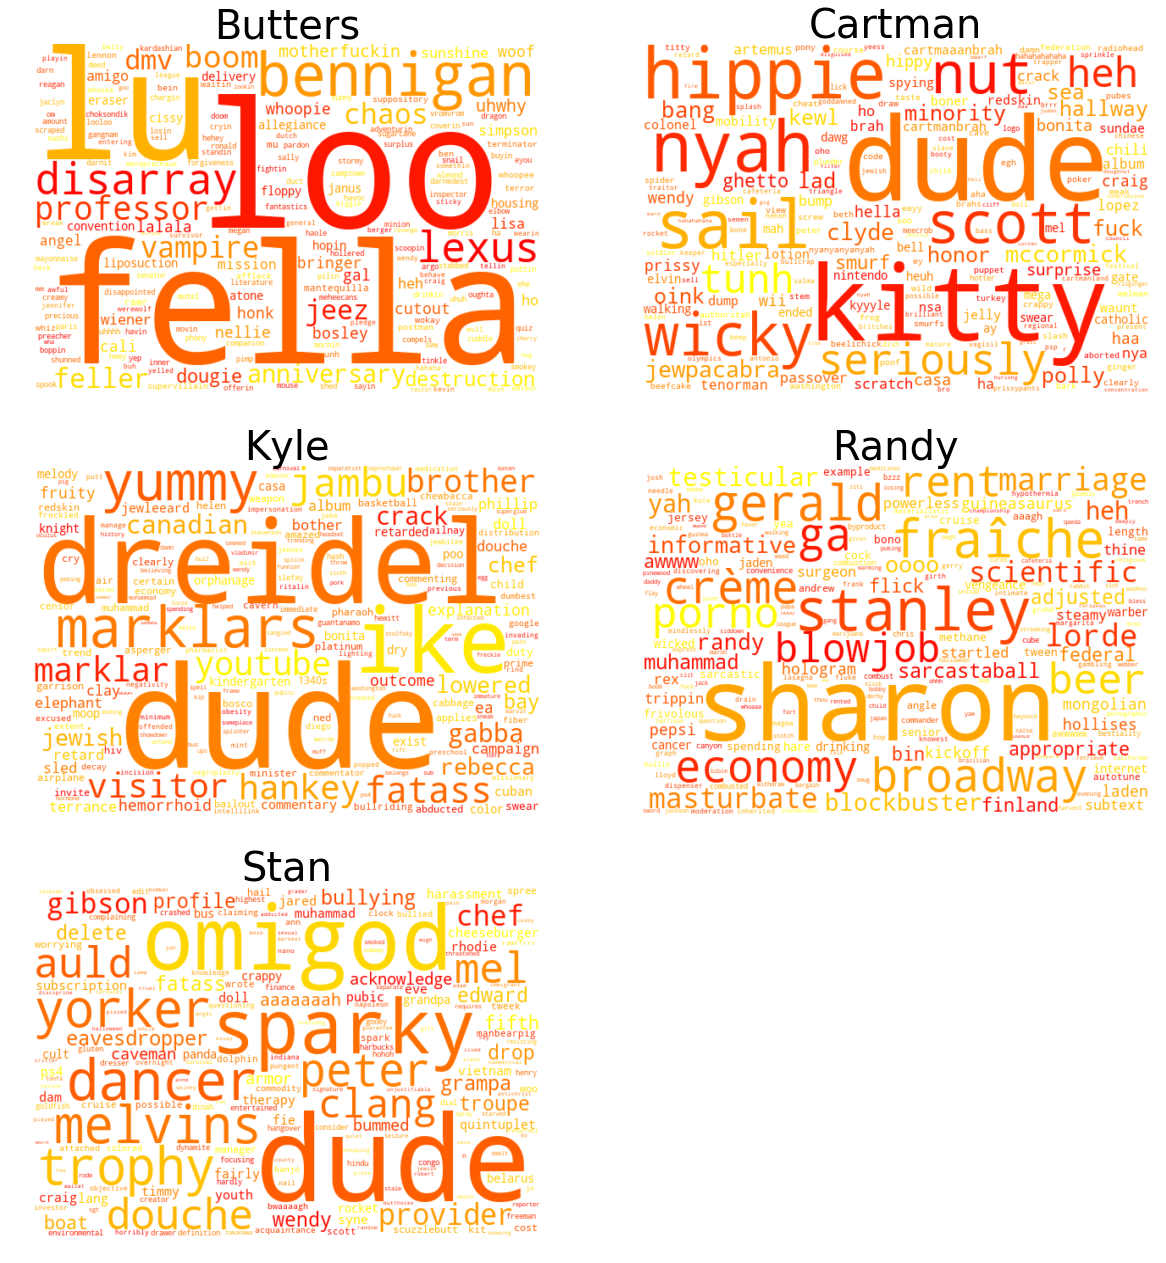

In [40]:
make_word_cloud(top.drop(top.index[nsfw_ix]), txt_col='norm',cat_col='Character')

This is pretty funny, and seems to match expectations - I can relate most words to a specific episode! We also see a few weird strings which migth be due to the lemmatisation process. However this is not the most informative visual to get an idea of overall content... Let's step it up using Bokeh and a method called TSNE which allows to visualise high dimensional data in 2D. 

# Bokeh visualisation of t-SNE components

First, we need to get tf-idf vectors for each normalised line - we can visualise what the algorithm is doing by putting these into a data frame indexed by line

In [41]:
vectorizer = TfidfVectorizer(min_df=4,lowercase=True, stop_words=None)
vz = vectorizer.fit_transform(top['norm'] )
pd.DataFrame(vz.toarray(),index=top['Line'],columns=vectorizer.get_feature_names()).head(3)

aa  \
Line                                                                                        
Chef said he's been bored, so he joining a group called the Super Adventure Club.     0.0   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!    0.0   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                           0.0   

                                                                                      aaaah  \
Line                                                                                          
Chef said he's been bored, so he joining a group called the Super Adventure Club.       0.0   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!      0.0   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                             0.0   

                                                                                      aaah  \
Line                                                                                         
Chef said he's been bored, so he joining a group called the Super Adventure Club.      0.0   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!     0.0   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                            0.0   

                                                                                      aaahhh  \
Line                                                                                           
Chef said he's been bored, so he joining a group called the Super Adventure Club.        0.0   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!       0.0   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                              0.0   

                                                                                      aaand  \
Line                                                                                          
Chef said he's been bored, so he joining a group called the Super Adventure Club.       0.0   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!      0.0   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                             0.0   

                                                                                      aah  \
Line                                                                                        
Chef said he's been bored, so he joining a group called the Super Adventure Club.     0.0   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!    0.0   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                           0.0   

                                                                                      ability  \
Line                                                                                            
Chef said he's been bored, so he joining a group called the Super Adventure Club.         0.0   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!        0.0   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                               0.0   

                                                                                      able  \
Line                                                                                         
Chef said he's been bored, so he joining a group called the Super Adventure Club.      0.0   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!     0.0   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                            0.0   

                                                                                      aborted  \
Line                                                                                            
Chef said he's been bored, so he joining a group called the Super Adventure Club.         0.0   
I'm

Next, we apply singular value decomposition (latent semantic analysis in NLP jargon) to reduce dimensionality and extract meaningful features from the corpus. We could apply t-SNE directly to the tf-idf vectors, but applying SVD first tends to result in nicer plots [(Source)](http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html).

In [42]:
lsa_inst = TruncatedSVD(n_components=50, random_state=42)
lsa = lsa_inst.fit_transform(vz)

We can get an idea of the composition of each component by putting the SVD vectors into a dataframe with each word as column

In [43]:
pd.DataFrame(lsa_inst.components_,columns = vectorizer.get_feature_names()).head()

aa     aaaah      aaah    aaahhh     aaand       aah   ability  \
0  0.001135  0.000987  0.002282  0.001087  0.001236  0.001694  0.001651   
1  0.000899 -0.000375 -0.001993 -0.001242 -0.001552 -0.002407 -0.000653   
2 -0.000586  0.000080 -0.000309  0.002719  0.000468  0.004784  0.002986   
3  0.000890  0.000174  0.000534  0.001018  0.001720  0.000709  0.001286   
4  0.000316 -0.001497 -0.002734 -0.001031 -0.000963 -0.001341 -0.000921   

       able   aborted  abortion    ...        young   younger   youtube  \
0  0.009867  0.001225  0.002664    ...     0.003243  0.001569  0.002921   
1 -0.004560 -0.001011 -0.003040    ...    -0.003047 -0.000078  0.000454   
2 -0.000660 -0.000539 -0.002452    ...     0.000246 -0.000269 -0.000795   
3 -0.003085 -0.000968 -0.002967    ...    -0.002280 -0.001947 -0.003274   
4 -0.000979 -0.000738  0.000013    ...     0.000232  0.001554  0.005172   

        yuh     yummy       yup     yyeah      zero  ziplining    zombie  
0  0.001662  0.000789  0.002682  0.000679  0.000990   0.002660  0.001687  
1 -0.000176 -0.000827  0.000861 -0.000722  0.001580  -0.002498  0.001404  
2  0.001149 -0.000399  0.000239  0.000119 -0.000529  -0.001661  0.000120  
3 -0.001657 -0.000595 -0.002332 -0.000766  0.000148  -0.001657 -0.001790  
4  0.002312 -0.001041  0.000265  0.001936 -0.000625  -0.004651  0.000982  

[5 rows x 2998 columns]

And similarly we can visualise the component composition of each line

In [44]:
pd.DataFrame(lsa, index = top['Line']).head(3)

0   \
Line                                                                                             
Chef said he's been bored, so he joining a group called the Super Adventure Club.     0.028296   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!    0.296141   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                           0.372519   

                                                                                            1   \
Line                                                                                             
Chef said he's been bored, so he joining a group called the Super Adventure Club.    -0.018508   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!    0.406078   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                           0.392447   

                                                                                            2   \
Line                                                                                             
Chef said he's been bored, so he joining a group called the Super Adventure Club.    -0.005192   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!    0.022942   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                          -0.087507   

                                                                                            3   \
Line                                                                                             
Chef said he's been bored, so he joining a group called the Super Adventure Club.    -0.011290   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!   -0.031924   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                           0.067041   

                                                                                            4   \
Line                                                                                             
Chef said he's been bored, so he joining a group called the Super Adventure Club.     0.001732   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!    0.037340   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                          -0.058417   

                                                                                            5   \
Line                                                                                             
Chef said he's been bored, so he joining a group called the Super Adventure Club.     0.005944   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!    0.070858   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                           0.072103   

                                                                                            6   \
Line                                                                                             
Chef said he's been bored, so he joining a group called the Super Adventure Club.     0.007888   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!    0.020925   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                          -0.067685   

                                                                                            7   \
Line                                                                                             
Chef said he's been bored, so he joining a group called the Super Adventure Club.     0.001400   
I'm gonna miss him.  I'm gonna miss Chef and I...and I don't know how to tell him!   -0.064461   
Dude, how are we gonna go on? Chef was our fuh...f-ffriend.                          -0.180185   

                                                                                            8   \
Line                                                              

And if we just look at the shape of the tfidf vectors and and lsa vectors, we can confirm that our vocabulary of almost 3000 words has been projected onto 50 components

In [45]:
print('tf-idf matrix shape:',vz.shape)
print('SVD matrix shape:',lsa.shape)

tf-idf matrix shape: (10272, 2998)
SVD matrix shape: (10272, 50)


Now we're ready to reduce our data dimensionality to 2 components using t-SNE

In [46]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=42)
tsne_lsa = tsne_model.fit_transform(lsa)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10272 samples in 0.047s...
[t-SNE] Computed neighbors for 10272 samples in 14.240s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10272
[t-SNE] Computed conditional probabilities for sample 2000 / 10272
[t-SNE] Computed conditional probabilities for sample 3000 / 10272
[t-SNE] Computed conditional probabilities for sample 4000 / 10272
[t-SNE] Computed conditional probabilities for sample 5000 / 10272
[t-SNE] Computed conditional probabilities for sample 6000 / 10272
[t-SNE] Computed conditional probabilities for sample 7000 / 10272
[t-SNE] Computed conditional probabilities for sample 8000 / 10272
[t-SNE] Computed conditional probabilities for sample 9000 / 10272
[t-SNE] Computed conditional probabilities for sample 10000 / 10272
[t-SNE] Computed conditional probabilities for sample 10272 / 10272
[t-SNE] Mean sigma: 0.064358
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.986649
[t-SNE] Er

Great! Let's visualise this in Bokeh

In [106]:
#Create new data frame mapping characters to a color
col_dict = {'Cartman': 'blue','Stan':'green', 'Kyle':'red','Randy' :'magenta', 'Butters':'black'}
col_df= top.replace({"Character": col_dict})

#Create source dictionary with all variables needed for bokeh plot
source = ColumnDataSource(dict(
    x=tsne_lsa[:, 0],
    y=tsne_lsa[:, 1],
    color= col_df['Character'].values,
    label=top['Character'].values,
    text =  top['Line']))

#Create figure object
plot = bp.figure(plot_width=900, plot_height=700
                       , title="South Park dialogue lines colored by speaker"
                       , tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave"
                       , x_axis_type=None, y_axis_type=None, min_border=1)

#Add one point per line, coloring by character
plot.scatter(x = 'x'
                   ,y='y'
                   ,color = 'color'
                    ,marker = 'o'
                   , legend = 'label'
                    ,source=source)

#Add hover functionality to display each line
hover = plot.select(dict(type=HoverTool))
hover.tooltips={"text": "@text"}

#Display Bokeh inline
output_notebook()
show(plot)
    

Loading BokehJS ...

Ok, we can see that Cartman speaks a lot... But we're not really seeing much distinction by character - it looks like it's not going to be easy to predict speaker using only the dialogue text! Just to compare, let's fit a K-Means algorithm with the same number of clusters as characters, and see how well the data can 'naturally' be separated into 5 clusters.

# Fit and visualise K-Means 

In [48]:
#Fit
km=KMeans(n_clusters=5)
km_fit = km.fit(vz)

In [49]:
#add K-Means cluster to original dataframe
top = top.assign(km_cluster = km_fit.labels_)

Let's check the distribution of character in each cluster

Text(0,0.5,'Frequency')

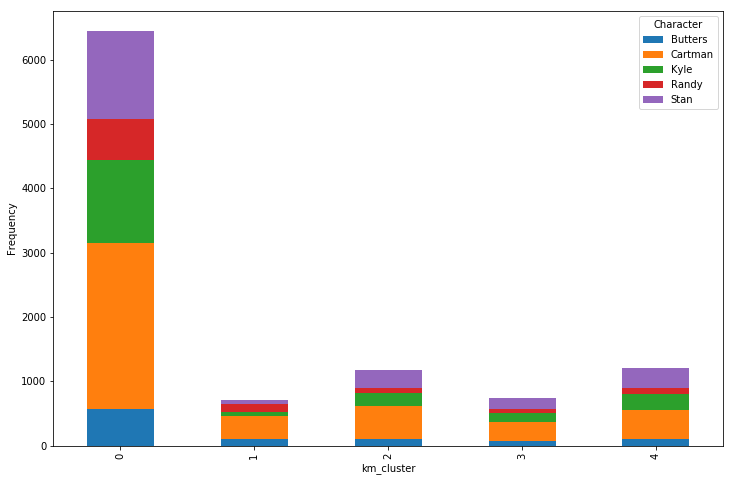

In [50]:
ax=top.groupby(['km_cluster', 'Character'])['km_cluster'].agg('count').unstack().plot.bar(stacked=True,figsize=(12, 8))
ax.set_ylabel("Frequency")

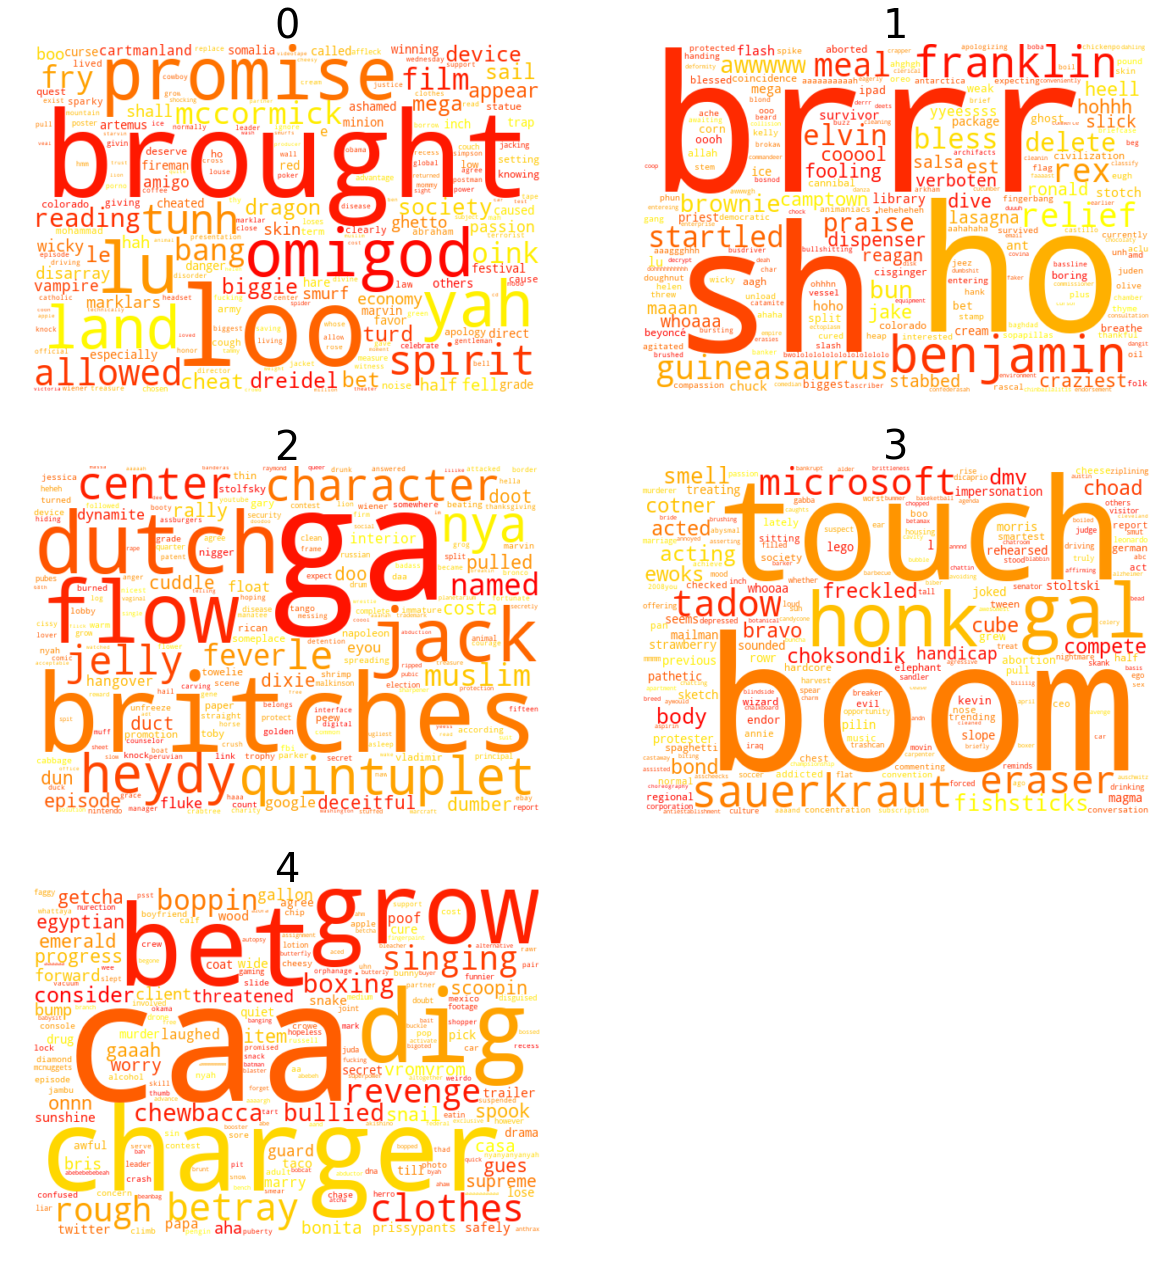

In [51]:
#Let's show a word cloud of the most distinctive words by cluster
make_word_cloud(top, 'norm', 'km_cluster')

I'm not really seeing any clear pattern - let's check using Bokeh

In [107]:
#Replace cluster id with a color
col_dict = {1: 'blue',2:'green', 3:'red',4 :'magenta', 0:'black'}
clus_col_df= top.replace({"km_cluster": col_dict})

#Create source dictionary
source = ColumnDataSource(dict(
    x=tsne_lsa[:, 0],
    y=tsne_lsa[:, 1],
    color=  clus_col_df['km_cluster'].values,
     label=top['km_cluster'].values,
    text =  top['Line'][:len(tsne_lsa)]  ))

#Initialise figure
plot_km = bp.figure(plot_width=900, plot_height=700
                       , title="Lines coloured by K-Means cluster (n clusters = 5)"
                       , tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave"
                       , x_axis_type=None, y_axis_type=None, min_border=1)
#Scatter plot
plot_km.scatter(x = 'x'
                   ,y='y'
                   ,color = 'color'
                ,legend='label'
                    ,source=source
               )
#Hover by line
hover = plot_km.select(dict(type=HoverTool))
hover.tooltips={"text": "@text"}

#Display Bokeh inline
output_notebook()
show(plot_km)

Loading BokehJS ...

Still not completely clear cut but clusters 2 and 4 are standing out more than any character did in the Bokeh plot by character. Let's do a broader exploration of the topics in South Park dialogues and build a topic model using [Latent Dirichlet Allocation](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/). The module pyLDAvis lets us create a great visualisation of the topics in a few lines of code!

# Exploring the dialogue topics - Latent Dirichlet Allocation

In [53]:
#this time we just need simple count vectors
cvectorizer = CountVectorizer(min_df=4)
cvz = cvectorizer.fit_transform(top['norm'])
tf_feature_names = cvectorizer.get_feature_names()

In [54]:
#Fit lda and dump model to pickle as it takes a while to run
n_topics = 15 #Arbitrarily deciding to try 15 topics
n_iter = 2000
n_top_words = 10
lda_model = LatentDirichletAllocation(n_topics=n_topics, max_iter=n_iter)
#X_topics = lda_model.fit(cvz)
#joblib.dump(X_topics, 'lda_SP_15topics.pkl')
#loads topics from file
X_topics = joblib.load('lda_SP_15topics.pkl')

To use the visualization below, click a circle in the left panel to select a topic, and the bar chart in the right panel will display the 30 most relevant terms for the selected topic. The red bars represent the frequency of a term in a given topic, and the blue bars represent a term's frequency across the entire corpus. Change the value of the λ parameter to adjust the term rankings: small values of λ highlight rare terms that are specific to the selected topic, and large values of λ highlight frequent, but not necessarily specific, terms for the selected topic. [(Source)](http://www.kennyshirley.com/LDAvis/)


In [108]:
#Visualise using LDAvis
prep = pyLDAvis.sklearn.prepare(X_topics, cvz, cvectorizer)
pyLDAvis.enable_notebook()
pyLDAvis.display(prep)

So it seems that topic 10 is mostly dedicated to Stan's mom... Let's take a look at the character distribution of each topic

In [56]:
#fit and transform the topics and dump to pickle as this takes a while to run
#topics_transformed = lda_model.fit_transform(cvz)
#joblib.dump(topics_transformed, 'lda_SP_fit_transform_15topics.pkl')
topics_transformed = joblib.load('lda_SP_fit_transform_15topics.pkl')

In [57]:
#Let's double check everything is working as planned by looking at the array shapes

print(cvz.shape) # Should be [n lines x n features] (features = words)
print(X_topics.components_.shape) # Should be [n topics x n features] (components_[i, j] represents word j in topic i)
print(topics_transformed.shape) #Should be [n lines x n topics]

(10272, 2998)
(15, 2998)
(10272, 15)


In [58]:
#Let's build a dataframe and assign each line to its highest ranking topic
topics_df = pd.DataFrame(topics_transformed)
#And now lets add character in the df so we can look at the character distribution of each topics
topics_df.index = top.index
topics_df = topics_df.join(top['Character'])

Text(0,0.5,'Count')

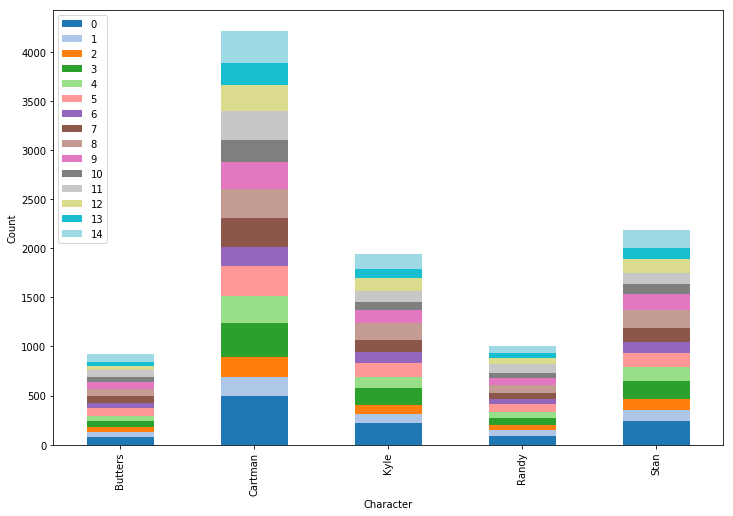

In [59]:
#plot the topic distribution of each charactere's lines
ax = topics_df.groupby('Character').agg('sum').plot.bar(stacked=True, figsize=(12, 8), colormap='tab20')
ax.set_ylabel("Count")

Text(0,0.5,'Frequency (/%)')

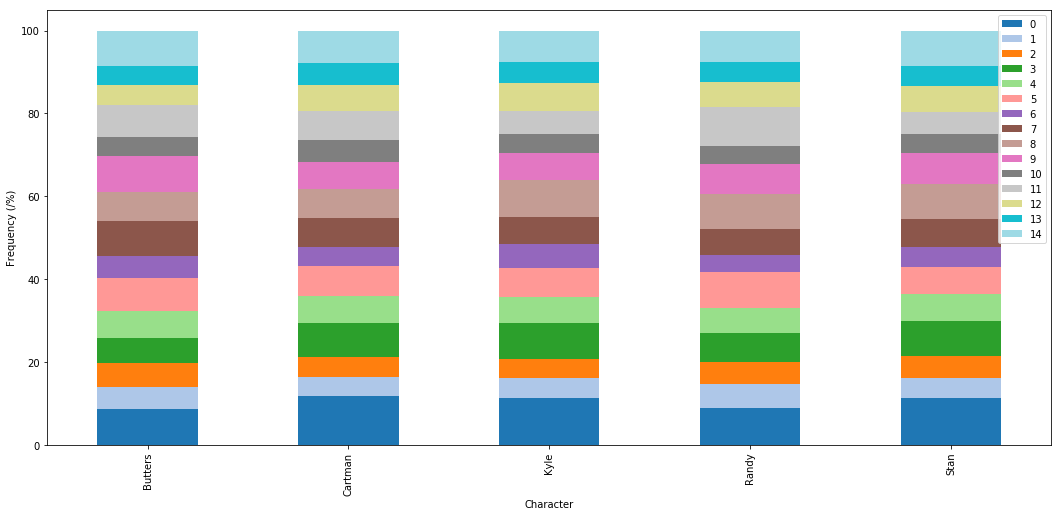

In [60]:
#plot the topic frequency distribution in percentage to account for differences in number of lines
tmp = topics_df.groupby('Character').agg('sum')
ax = tmp.div(
    tmp.sum(
        axis=1), axis=0).apply(
    lambda x: x*100).groupby(
    'Character').agg(
    'sum').plot.bar(
    stacked=True, figsize=(18, 8), colormap='tab20') 
ax.set_ylabel("Frequency (/%)")

Let's move away from exploring the data and try building some models to predict the speaker from a line's text content. 

# Predicting character from lines

Let's start with a simple model using only count vectors from the normalised text column. We'll compare a Naive Bayes model, frequently used for text classification, and a random forest. 

In [73]:
#Feature extraction
vz = CountVectorizer(min_df = 5, lowercase = False, ngram_range=(1, 3))
X = vz.fit_transform(top['norm']).toarray()
y = top['Character']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)    

In [74]:
#Build NB classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('NB Accuracy:', accuracy_score(y_test, y_pred))

NB Accuracy: 0.5067846607669616


In [75]:
#Build RF classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('RF Accuracy:', accuracy_score(y_test, y_pred))

RF Accuracy: 0.47581120943952804


The naive Bayes is performing better than the random forest, but the accuracy is pretty low at around 50%. Let's see if we can improve it by adding more features to characterise a line that could potentially distinguish characters. I'm going to add:
- The average word length in a line (perhaps Randy and Kyle use longer words than Butters?)
- The number of words in a line (from the distributions plotted at the beginning it seems Cartman and Randy user longer sentences)
- The proportion of words that aren't standard English. I'm going to use the NLTK [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) to assess this. I am hoping this will highlight characters that use a lot of modern slang or swearwords that won't be in the corpus.
- Finally I'm going to include Season as a categorical variable with 18 levels - it's a lot of levels but I think it is possible different characters have more/fewer lines depending on the season, and also that they use different words as the plot unravels trhoughout the seasons. 

We'll use the feature union sklearn functionality to build a pipeline, and use GridSearch to fidn the best hyperparameters. [Zac Stewart](http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html)'s and [Michelle Fullwood](http://michelleful.github.io/code-blog//2015/06/20/pipelines/)'s posts were great sources of inspiration for this piece of work. 

In [76]:
#First let's replace the NaN by blank spaces, to account for lines where the normalised text column is empty (e.g if the line contained only stopwords)
top = top.fillna(' ')

In [77]:
# Import the Brown vocabulary
word_list = brown.words()
word_set = set(word_list)

In [78]:
#Define some custom transformers to bring the extra variables into the pipeline
class DataFrameColumnExtractor(BaseEstimator, TransformerMixin):
    """Takes in column name, outputs desired pandas dataframe column"""
    
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class AverageWordLengthCalculator(BaseEstimator, TransformerMixin):
    """Takes in dataframe column, outputs average word length of a row"""

    def __init__(self):
        pass

    def transform(self, df_column):
        """Helper code to compute average word length of a line"""
        average_length = df_column.apply(lambda x: np.mean([len(word) for word in x.split()]))
        average_length = average_length.replace(np.nan, 0)
        return average_length
    
    def fit(self, df, y=None):
        return self
    
class WordCountCalculator(BaseEstimator, TransformerMixin):
    """Takes in dataframe column, outputs number of words in each row"""

    def __init__(self):
        pass

    def transform(self, df_column):
        """Helper code to compute the number of words"""
        n_words = df_column.apply(lambda x: len(str(x).split()))
        n_words = n_words.replace(np.nan, 0)
        return n_words
    
    def fit(self, df, y=None):
        return self
    
class ProportionNotBrownCalculator(BaseEstimator, TransformerMixin):
    """Takes in dataframe column, outputs the proportion of words that are not in Brown corpus in each row"""

    def __init__(self):
        pass
    
    def transform(self, df_column):
        """Helper code to compute proportion of words that aren't in Brown corpus"""
        pct_misspelled =  df_column.apply(lambda x: sum(
            [word not in word_set for word in str(x).split()]
        ) / sum(
            [len(str(x).split()) if len(str(x).split()) > 0 else 1]
        )
                                         )
        return pct_misspelled
    
    def fit(self, df, y=None):
        return self
    
class ArrayShaper(BaseEstimator, TransformerMixin):
    """Reshapes array into shape expected by sklearn"""
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return data.values.reshape(-1, 1)

In [79]:
#Build the pipeline to bring it all together
pipeline = Pipeline([
        
  ('features', FeatureUnion(
          
          transformer_list = [
                  #First, the text features
                  ('text', Pipeline([
                          ('extract_line', DataFrameColumnExtractor('norm')),
                          ('tfidf', TfidfVectorizer())
                          ])),
              
                  #Average word length in line
                    ('word_length', Pipeline([
                         ('extract_line', DataFrameColumnExtractor('norm')),
                         ('word_length', AverageWordLengthCalculator()), 
                         ('cast', ArrayShaper())                  
                         ])),
              
                #Number of words in line           
                  ('n_words', Pipeline([
                          ('extract_line', DataFrameColumnExtractor('norm')),
                         ('word_count', WordCountCalculator()), 
                         ('cast', ArrayShaper())                  
                         ])),

                #Proportion of words not in Brown corpus
                  ('brown', Pipeline([
                        ('extract_line', DataFrameColumnExtractor('norm')),
                        ('prop_misspelt',ProportionNotBrownCalculator()),
                        ('cast', ArrayShaper())
                       ])),
              
              #Finally the season
                  ('season', Pipeline([
                         ('extract_season', DataFrameColumnExtractor('Season')),
                         ('cast', ArrayShaper()),
                          ('encode_int', OneHotEncoder())
                         ]))                    
 
           ])),
  #Stick with Naive Bayes to classify                
  ('classifier',MultinomialNB())
    ])

In [80]:
#Now let's build the grid of hyperparameters to fit. 
#I'm not going to fiddle with the NB itself, but instead I'm going to explore different feature extraction parameters for the free text
grid = {'features__text__tfidf__ngram_range': [(1, 1),(1, 2), (1, 3),(1, 4)],
        'features__text__tfidf__min_df': [1, 3, 5, 10],   
        'features__text__tfidf__max_features':  [None, 5000, 10000, 50000],
        'features__text__tfidf__use_idf':  [True, False],
        'features__text__tfidf__norm': [None, 'l1', 'l2']}

In [87]:
#Fit the grid
X = top
y = top['Character']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43) 
cv = GridSearchCV(pipeline, param_grid=grid,  scoring='f1_micro')
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

In [95]:
#Print the best parameters
print('Best parameters',cv.best_params_)

Best parameters {'features__text__tfidf__max_features': None, 'features__text__tfidf__min_df': 3, 'features__text__tfidf__ngram_range': (1, 2), 'features__text__tfidf__norm': None, 'features__text__tfidf__use_idf': False}


Interestingly, the best parameters are to not use idf and not normalise the count, which means the best features are essentially just a raw count. LEt's check whether we've improved accuracy 

In [86]:
print(accuracy_score(y_test, y_pred))

0.5300884955752212


Well this was a lot of work for a small improvement in accuracy... Let's see more details about how the algorithm is performing

In [83]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

    Butters       0.71      0.33      0.45       328
    Cartman       0.56      0.75      0.64      1367
       Kyle       0.42      0.32      0.36       654
      Randy       0.63      0.32      0.43       330
       Stan       0.39      0.41      0.40       711

avg / total       0.52      0.51      0.50      3390



In [98]:
#print confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted  Butters  Cartman  Kyle  Randy  Stan   All
True                                                
Butters         75      158    23      8    36   300
Cartman         14     1082    96     12   166  1370
Kyle             6      259   215      7   158   645
Randy           11      160    36     91    54   352
Stan             9      294   116     10   294   723
All            115     1953   486    128   708  3390

It looks like the most difficult task is detecting (recalling) lines belonging to Butters, Kyle and Randy. Precision is low for Kyle and Cartman, meaning that a lot of lines are wrongly attributed to them. Kyle has the lowest f1 score overall - his speech is too similar to Cartman's and Stan's, so his lines are wrongly attributed to them, or their lines to him, which is lowering the performance of the model. Let's see how much the model would improve if we gave up on identifying Kyle and excluded him.

In [104]:
#Fit the grid
no_kyle=top[top['Character']!='Kyle']
X = no_kyle
y = no_kyle['Character']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43) 
cv = GridSearchCV(pipeline, param_grid=grid,  scoring='f1_micro')
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

In [105]:
print(accuracy_score(y_test, y_pred))

0.6202255365587487


In conclusion, we are able to classify whether a line belongs to Cartman, Randy, Stan or Butters with approximately 60% accuracy! 
